# Packet delays and correlations

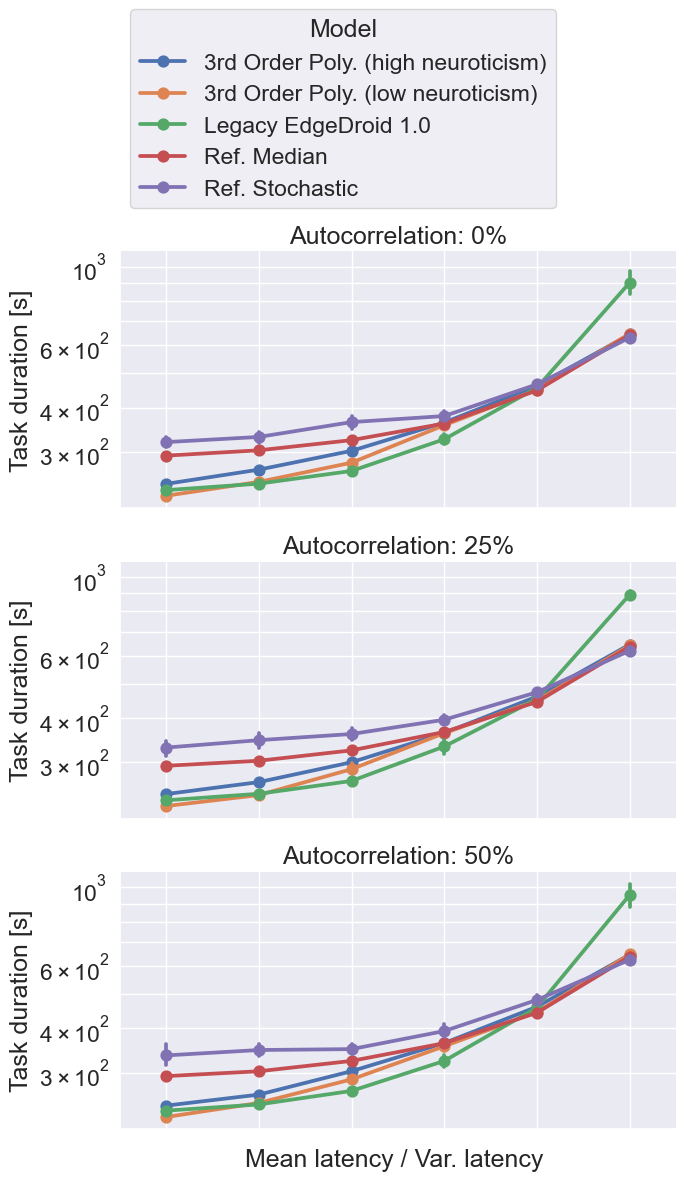

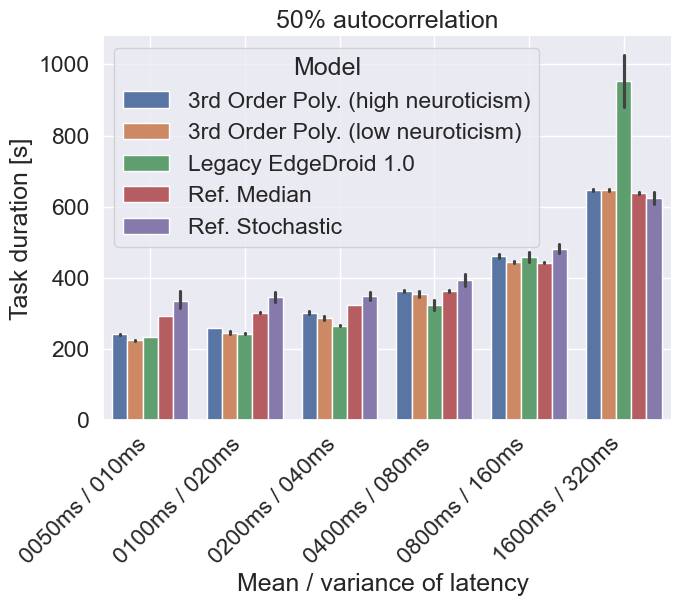

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{task_duration_diff_high_neuro} & \multicolumn{2}{r}{task_duration_diff_low_neuro} \\
lat_var & 0050ms / 010ms & 1600ms / 320ms & 0050ms / 010ms & 1600ms / 320ms \\
model &  &  &  &  \\
\midrule
3rd Order Poly. (high neuroticism) & NaN & NaN & $ +7.7\% $ & $ -0.2\% $ \\
3rd Order Poly. (low neuroticism) & $ -7.1\% $ & $ +0.2\% $ & NaN & NaN \\
Legacy EdgeDroid 1.0 & $ -3.2\% $ & $ +47.4\% $ & $ +4.2\% $ & $ +47.0\% $ \\
Ref. Median & $ +21.2\% $ & $ -1.3\% $ & $ +30.5\% $ & $ -1.5\% $ \\
Ref. Stochastic & $ +38.6\% $ & $ -3.3\% $ & $ +49.3\% $ & $ -3.5\% $ \\
\bottomrule
\end{tabular}



/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/1454265507.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[0, 1]).transform("first")
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/1454265507.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[0, 1]).transform("first")

task_duration_diff_high_neuro  \
lat_var        one_way_corr model                                                 
0050ms / 010ms 50           Legacy EdgeDroid 1.0                      -0.032153   
                            Ref. Median                                0.211569   
                            Ref. Stochastic                            0.386146   
1600ms / 320ms 50           Legacy EdgeDroid 1.0                       0.473680   
                            Ref. Median                               -0.012850   
                            Ref. Stochastic                           -0.032948   

                                                  task_duration_diff_low_neuro  
lat_var        one_way_corr model                                               
0050ms / 010ms 50           Legacy EdgeDroid 1.0                      0.042364  
                            Ref. Median                               0.304851  
                            Ref. Stochastic                           0.492870  
1600ms / 320ms 50           Legacy EdgeDroid 1.0                      0.470404  
                            Ref. Median                              -0.015044  
                            Ref. Stochastic                          -0.035098

In [81]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import parse
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_path = Path("./output")
timing_fmt_matcher = parse.compile("lat{latency:d}_var{variance:d}_corr{corr:d}")
exp_fmt_matcher = parse.compile("{model_name}_{rep:d}_of_{total_reps:d}")

dfs = deque()

for exp_dir in base_path.iterdir():
    res = timing_fmt_matcher.parse(exp_dir.name)
    one_way_latency = res["latency"]
    one_way_variance = res["variance"]
    one_way_corr = res["corr"]
    lat_var = f"{one_way_latency:04d}ms / {one_way_variance:03d}ms"
    for rep_dir in exp_dir.iterdir():
        res = exp_fmt_matcher.parse(rep_dir.name)
        model = res["model_name"]
        rep = res["rep"]

        steps_file = rep_dir / "client.steps.csv"
        steps_csv = pd.read_csv(steps_file)

        steps_csv["one_way_latency"] = one_way_latency
        steps_csv["one_way_variance"] = one_way_variance
        steps_csv["model"] = model
        steps_csv["rep"] = rep
        steps_csv["one_way_corr"] = one_way_corr
        steps_csv["lat_var"] = lat_var

        dfs.append(steps_csv)

data = pd.concat(dfs, ignore_index=True)
data["task_duration"] = data.groupby(["one_way_latency", "one_way_variance", "one_way_corr", "model", "rep"])["step_duration"].cumsum()
lat_var = pd.CategoricalDtype(sorted(data["lat_var"].unique()), ordered=True)
data["lat_var"] = data["lat_var"].astype(lat_var)

data["model"] = data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "curve-low-neuro": "3rd Order Poly. (low neuroticism)",  # multi-curve always fits 3rd
    "curve-high-neuro": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")

sns.set_context("paper")
sns.set(font_scale=1.5)
DOUBLE_COL_FIGW = 7.16

last_step_data = data[data["step_number"] == data["step_number"].max()]
# last_step_data = last_step_data[np.isin(last_step_data["one_way_corr"], (0, 50))]


fg = sns.catplot(
    kind="point",
    data=last_step_data,
    x="lat_var",
    y="task_duration",
    row="one_way_corr",
    hue="model",
    legend=True,
    legend_out=False,
    col_wrap=None,
    aspect=1,
)
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

fg.set_axis_labels("Mean latency / Var. latency ", "Task duration [s]")
fg.set_titles(col_template="Autocorrelation: {col_name}%", row_template="Autocorrelation: {row_name}%")
fg.legend.set_title("Model")
sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.2), ncols=1)

fg.set(yscale="log")
# tpl.save("./frame_corr_task_dur.tex")
fg.figure.set_size_inches((2*3.6, 2*5))
fg.tight_layout()
plt.show()

fg = sns.catplot(
    kind="bar",
    data=last_step_data[last_step_data.one_way_corr == 50],
    x="lat_var",
    y="task_duration",
    row="one_way_corr",
    hue="model",
    legend=True,
    legend_out=False,
    col_wrap=None,
    aspect=1,
)
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

fg.set_axis_labels("Mean / variance of latency ", "Task duration [s]")
fg.set_titles(col_template="Autocorrelation: {col_name}%", row_template="{row_name}% autocorrelation")
fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.2), ncols=1)

fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.55), ncols=1)
fg.figure.set_size_inches((2*3.6, 2*3.2))
fg.tight_layout()
plt.show()

mean_task_duration = last_step_data.groupby(["lat_var", "one_way_corr", "model"], observed=True)["task_duration"].mean().to_frame()
a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[0, 1]).transform("first")
diff_wrt_hn = (mean_task_duration["task_duration"] - a) / a

a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[0, 1]).transform("first")
diff_wrt_ln = (mean_task_duration["task_duration"] - a) / a

diff_wrt_realistic = pd.merge(diff_wrt_hn, diff_wrt_ln, left_index=True, right_index=True, how="inner", suffixes=("_diff_high_neuro", "_diff_low_neuro")).replace(0.0, np.NaN)

relevant_diffs = diff_wrt_realistic[
    (mean_task_duration.index.get_level_values("one_way_corr") == 50)
    & (
            (mean_task_duration.index.get_level_values("lat_var") == "0050ms / 010ms")
            | (mean_task_duration.index.get_level_values("lat_var") == "1600ms / 320ms")
    )
    ]

print(relevant_diffs.unstack(level=0).droplevel(level=0).to_latex(
    float_format=lambda f: f"$ {f * 100.0:+0.1f}\\% $",
))

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/2703973429.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  plot_diffs["model"] = plot_diffs["model"].replace(to_replace="Legacy EdgeDroid 1.0", value="Legacy")


,lat_var,one_way_corr,model,diff_wrt,diff
0,0050ms / 010ms,50,Legacy,Legacy diff. w.r.t. high neuro.,-0.032153
1,0050ms / 010ms,50,Legacy,Legacy diff. w.r.t. low neuro.,0.042364
2,0050ms / 010ms,50,Ref. Median,Ref. Median diff. w.r.t. high neuro.,0.211569
3,0050ms / 010ms,50,Ref. Median,Ref. Median diff. w.r.t. low neuro.,0.304851
4,0050ms / 010ms,50,Ref. Stochastic,Ref. Stochastic diff. w.r.t. high neuro.,0.386146
5,0050ms / 010ms,50,Ref. Stochastic,Ref. Stochastic diff. w.r.t. low neuro.,0.492870
6,1600ms / 320ms,50,Legacy,Legacy diff. w.r.t. high neuro.,0.473680
7,1600ms / 320ms,50,Legacy,Legacy diff. w.r.t. low neuro.,0.470404
8,1600ms / 320ms,50,Ref. Median,Ref. Median diff. w.r.t. high neuro.,-0.012850
9,1600ms / 320ms,50,Ref. Median,Ref. Median diff. w.r.t. low neuro.,-0.015044


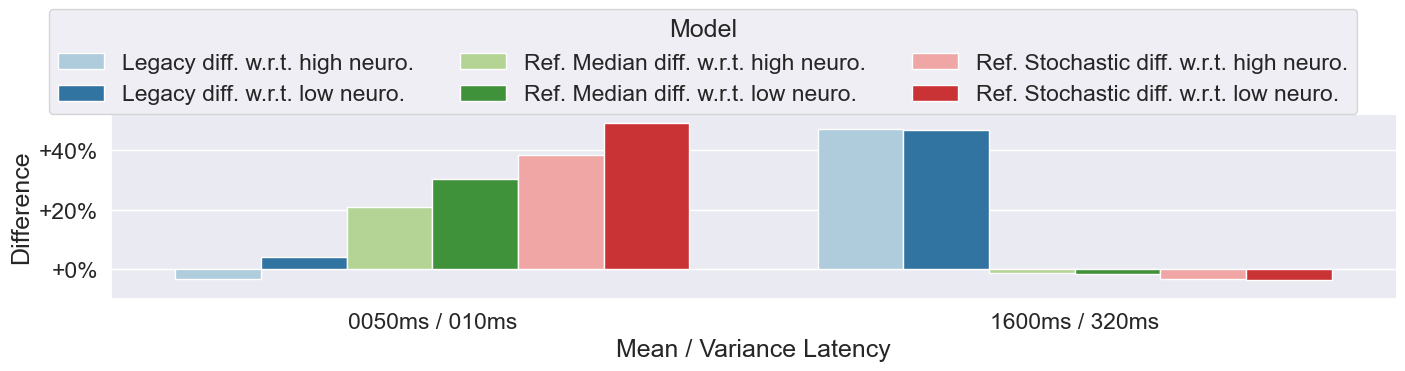

In [101]:
plot_diffs = (
    relevant_diffs[~np.isin(relevant_diffs.reset_index()["model"], ["3rd Order Poly. (high neuroticism)", "3rd Order Poly. (low neuroticism)"])]
    .stack()
    .reset_index()
    .rename(columns={"level_3": "diff_wrt", 0: "diff"})
)
plot_diffs["model"] = plot_diffs["model"].replace(to_replace="Legacy EdgeDroid 1.0", value="Legacy")

plot_diffs["diff_wrt"] = plot_diffs[["model", "diff_wrt"]].apply(lambda row: f"{row.model} diff. w.r.t. {'high' if 'high' in row.diff_wrt else 'low'} neuro.", axis=1)
plot_diffs["lat_var"] = plot_diffs["lat_var"].cat.remove_unused_categories()

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(kind="bar", data=plot_diffs, x="lat_var", y="diff", hue="diff_wrt", legend_out=False, palette="Paired")
fg.set_axis_labels(r"Mean / Variance Latency", "Difference")
fg.set(ylim=(-0.1, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.3), ncols=3)
fg.figure.set_size_inches((2*7.2, 2*1.5))
fg.tight_layout()

plot_diffs

# Per-frame delays and correlations

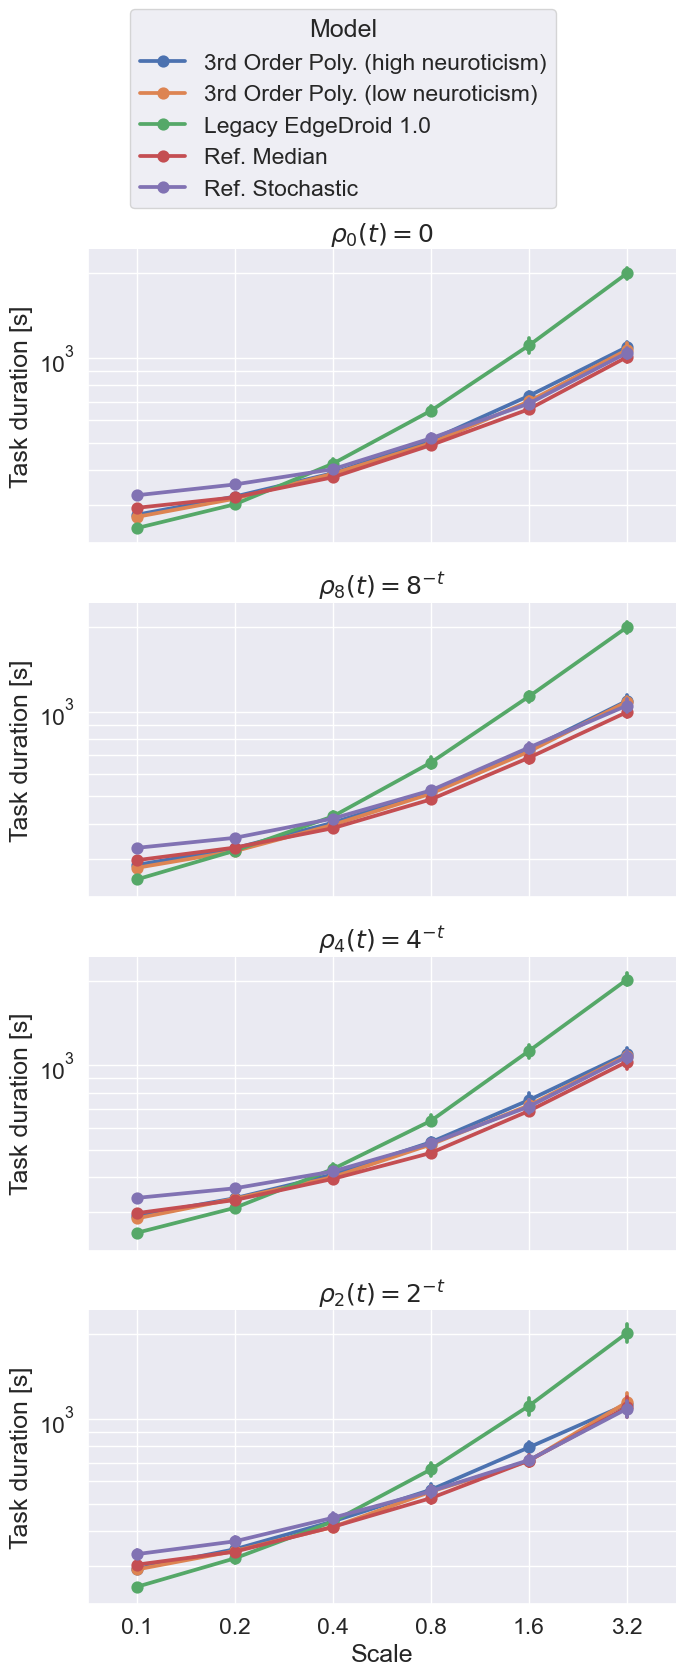

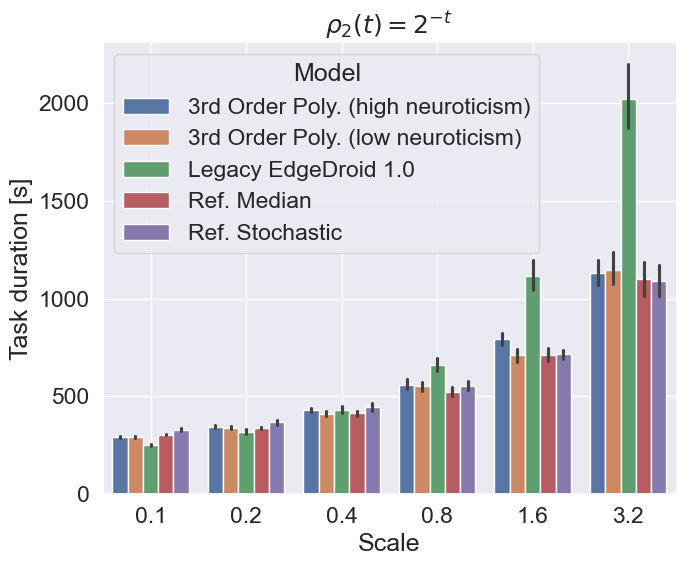

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/1956502814.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["model", "rho", "scale"])["step_duration"]
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/1956502814.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[1, 2]).transform("first")
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/1956502814.py:86: FutureWarning: The default of observed=False is deprecat

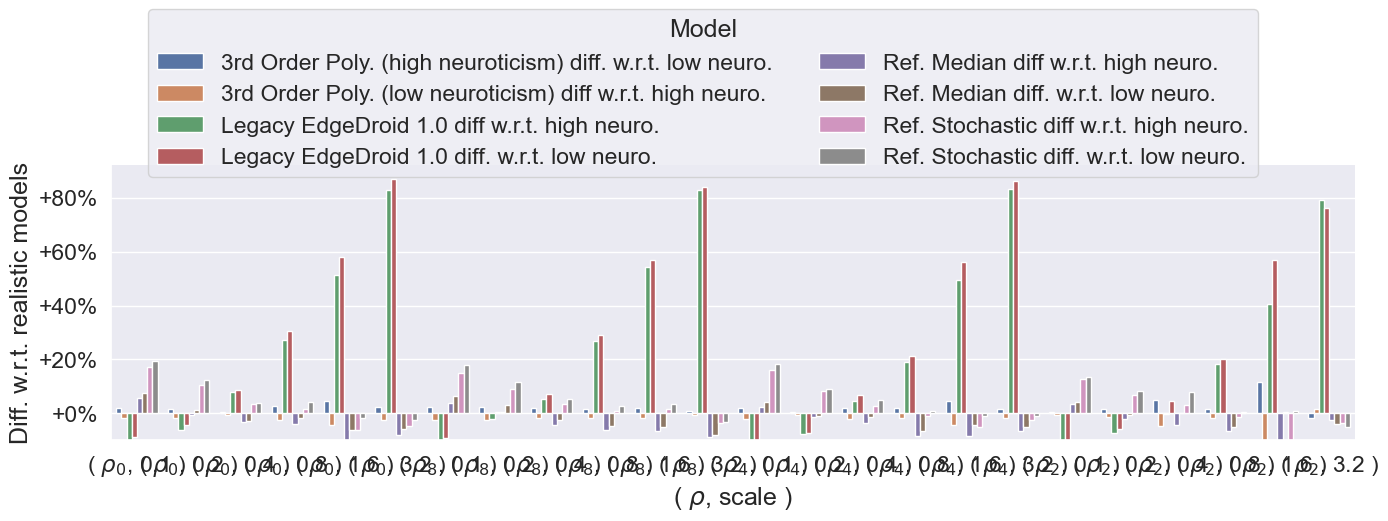

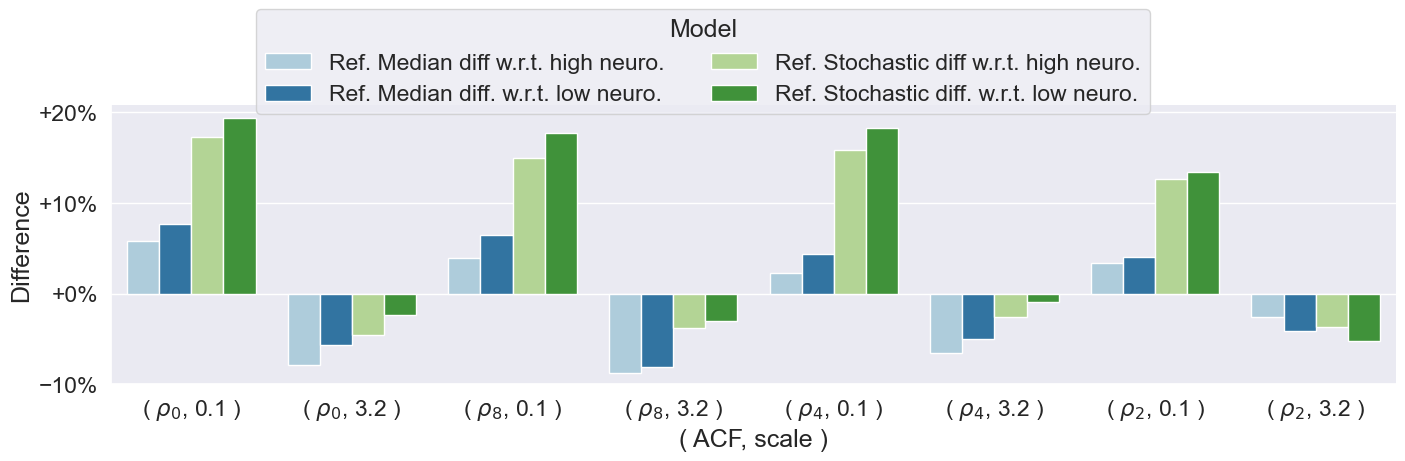

In [95]:
frame_data = pd.read_csv('./per_frame_delay_fixed.csv')

rhos = {
    0.0: r"$ \rho_0(t) = 0 $",
    0.5: r"$ \rho_2(t) = 2^{-t} $",
    0.25: r"$ \rho_4(t) = 4^{-t} $",
    0.125: r"$ \rho_8(t) = 8^{-t} $"
}

frame_data["rho"] = frame_data["rho"].replace(rhos).astype(pd.CategoricalDtype(
    [rhos[0.0], rhos[0.125], rhos[0.25], rhos[0.5]],
    ordered=True,
))

frame_data["scale"] = frame_data["scale"].astype(pd.CategoricalDtype([0.1, 0.2, 0.4, 0.8, 1.6, 3.2], ordered=True))

frame_data["model"] = frame_data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "3rd-poly-low": "3rd Order Poly. (low neuroticism)",
    "3rd-poly-high": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")

total_durations = frame_data.groupby(["model", "rep", "rho", "scale"], observed=True)["step_duration"].sum().reset_index()

sns.set_context("paper")
sns.set(font_scale=1.5)
DOUBLE_COL_FIGW = 7.16

fg = sns.catplot(kind="point", data=total_durations, hue="model", y="step_duration", x="scale", row="rho", aspect=1,
                 legend_out=False)
fg.set_axis_labels(r"Scale", "Task duration [s]")
fg.set_titles(row_template=r"{row_name}")
fg.set(yscale="log")

for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yscale("log", base=2)
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

# fg.set(yscale="log")

fg.legend.set_title("Model")
sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.13), ncols=1)
fg.figure.set_size_inches((2 * 3.6, 2 * 7.5))
fg.tight_layout()
plt.show()

total_durations_rho2 = total_durations[total_durations["rho"] == rhos[0.5]].copy()
total_durations_rho2["rho"] = total_durations_rho2["rho"].cat.remove_unused_categories()

fg = sns.catplot(kind="bar", data=total_durations_rho2, hue="model", y="step_duration", x="scale", row="rho", aspect=1,
                 legend_out=False)
fg.set_axis_labels(r"Scale", "Task duration [s]")
fg.set_titles(row_template=r"{row_name}")
# fg.set(yscale="log")

for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yscale("log", base=2)
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

# fg.set(yscale="log")

fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.55), ncols=1)
fg.figure.set_size_inches((2 * 3.6, 2 * 3.0))
fg.tight_layout()
plt.show()

# diff
mean_total_durations = (
    total_durations
    .groupby(["model", "rho", "scale"])["step_duration"]
    .mean()
)

a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[1, 2]).transform("first")
diff_wrt_hn = (mean_total_durations - a) / a

a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[1, 2]).transform("first")
diff_wrt_ln = (mean_total_durations - a) / a

diff_wrt_realistic = pd.merge(diff_wrt_hn, diff_wrt_ln, left_index=True, right_index=True, how="inner", suffixes=("_diff_high_neuro", "_diff_low_neuro")).replace(0.0, np.NaN).reset_index()
diff_wrt_realistic = diff_wrt_realistic.set_index(["model", "rho", "scale"]).stack().reset_index().rename(columns={"level_3": "wrt", 0: "diff"})
diff_wrt_realistic["wrt"] = diff_wrt_realistic["wrt"].apply(lambda x: "diff. w.r.t. low neuro." if x.split("_")[-2] == "low" else "diff w.r.t. high neuro.")

diff_wrt_realistic["rho_scale"] = diff_wrt_realistic[["rho", "scale"]].apply(lambda row: f"( {row.rho[:8]} $, {row.scale} )" , axis=1)
diff_wrt_realistic["model_wrt"] = diff_wrt_realistic[["model", "wrt"]].apply(lambda row: f"{row.model} {row.wrt}" , axis=1)

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(kind="bar", data=diff_wrt_realistic, x="rho_scale", hue="model_wrt", y="diff", legend_out=False)
fg.set_axis_labels(r"( $\rho$, scale )", "Diff. w.r.t. realistic models")
fg.set(ylim=(-0.1, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.35), ncols=2)
fg.figure.set_size_inches((2*7.2, 2*2))
fg.tight_layout()
plt.show()

diff_wrt_realistic_ext = diff_wrt_realistic[
    np.isin(diff_wrt_realistic["scale"], (0.1, 3.2))
    & ~np.isin(diff_wrt_realistic["model"], ("Legacy EdgeDroid 1.0", "3rd Order Poly. (high neuroticism)", "3rd Order Poly. (low neuroticism)"))
    ].copy()
diff_wrt_realistic_ext["model"] = diff_wrt_realistic_ext["model"].cat.remove_unused_categories()
diff_wrt_realistic_ext["scale"] = diff_wrt_realistic_ext["scale"].cat.remove_unused_categories()

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(kind="bar", data=diff_wrt_realistic_ext, x="rho_scale", hue="model_wrt", y="diff", legend_out=False, palette="Paired")
fg.set_axis_labels(r"( ACF, scale )", "Difference")
fg.set(ylim=(-0.1, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=2)
fg.figure.set_size_inches((2*7.2, 2*2))
fg.tight_layout()
plt.show()

# Per-step delays and correlations

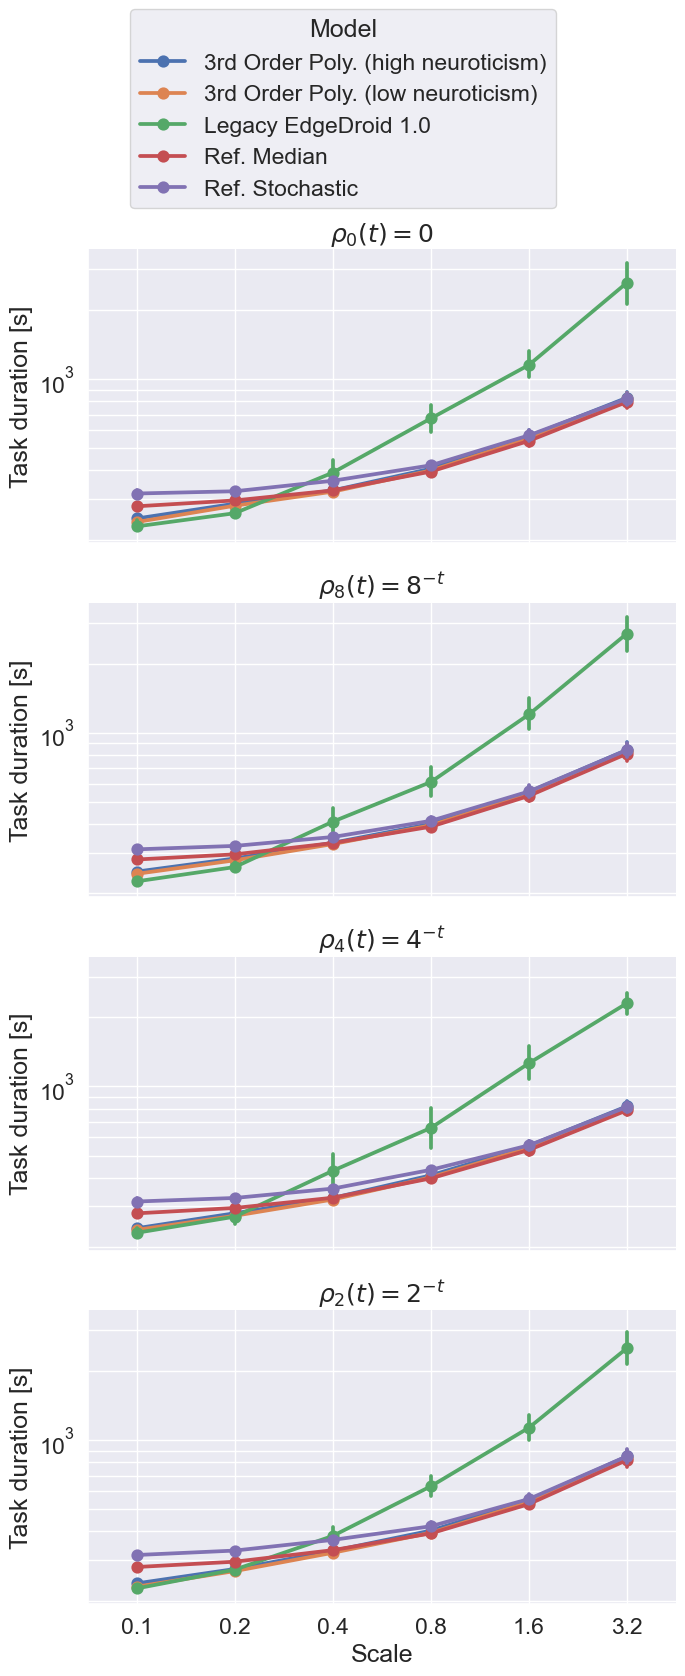

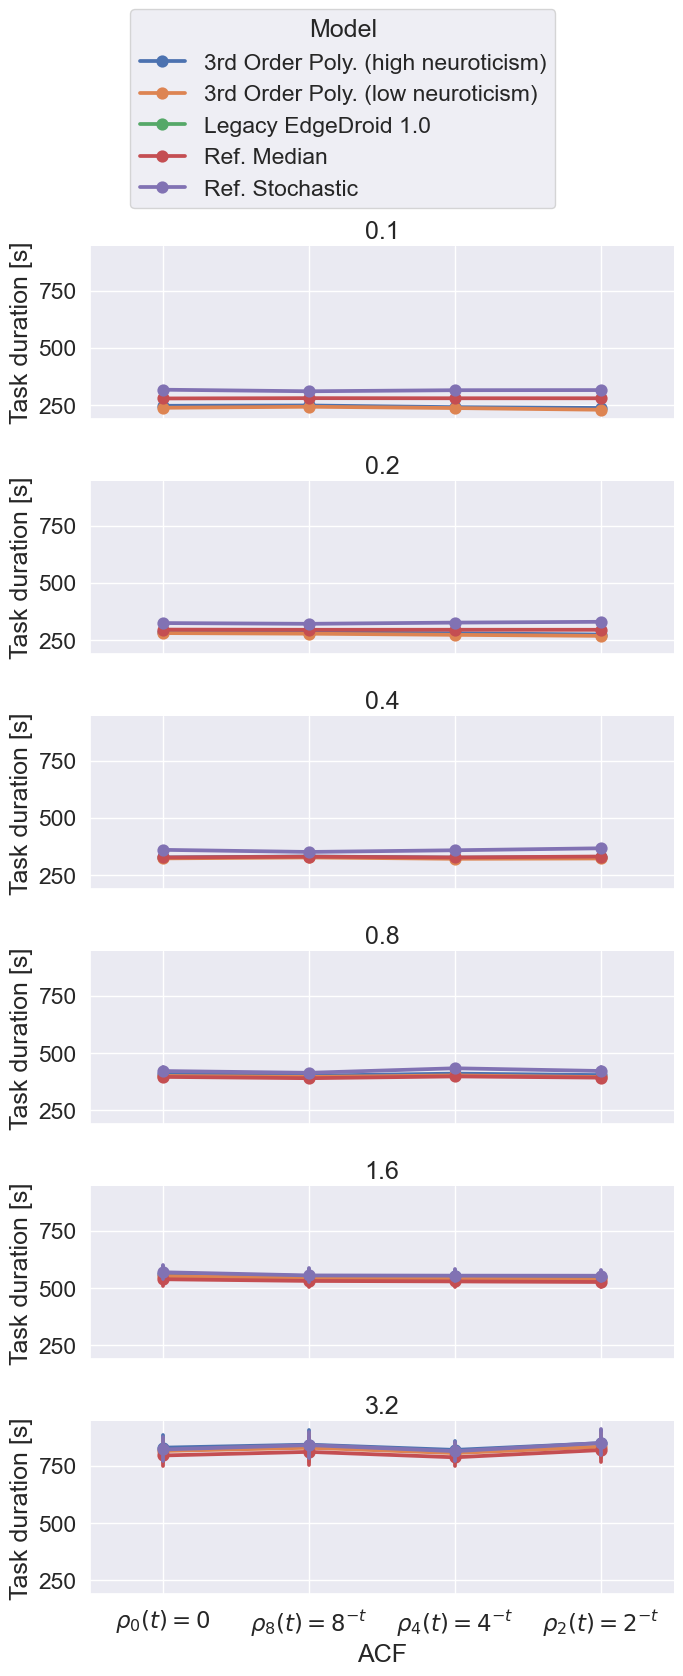

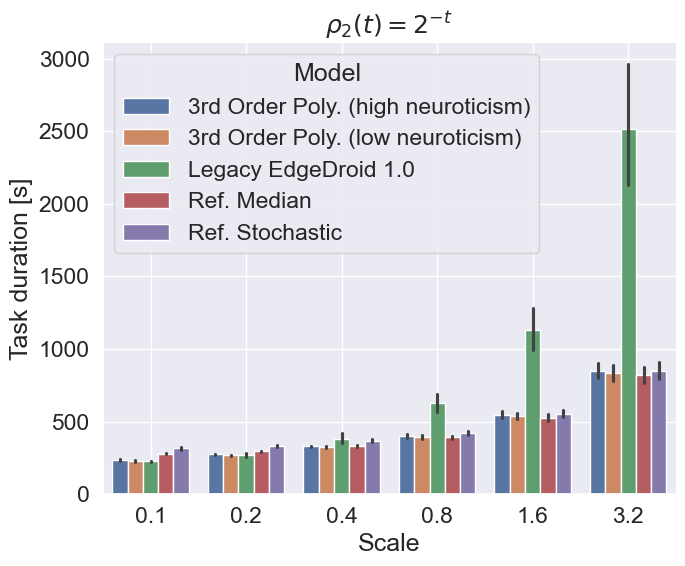

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/572027702.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["model", "rho", "scale"])["step_duration"]
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/572027702.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[1, 2]).transform("first")
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/572027702.py:99: FutureWarning: The default of observed=False is deprecated 

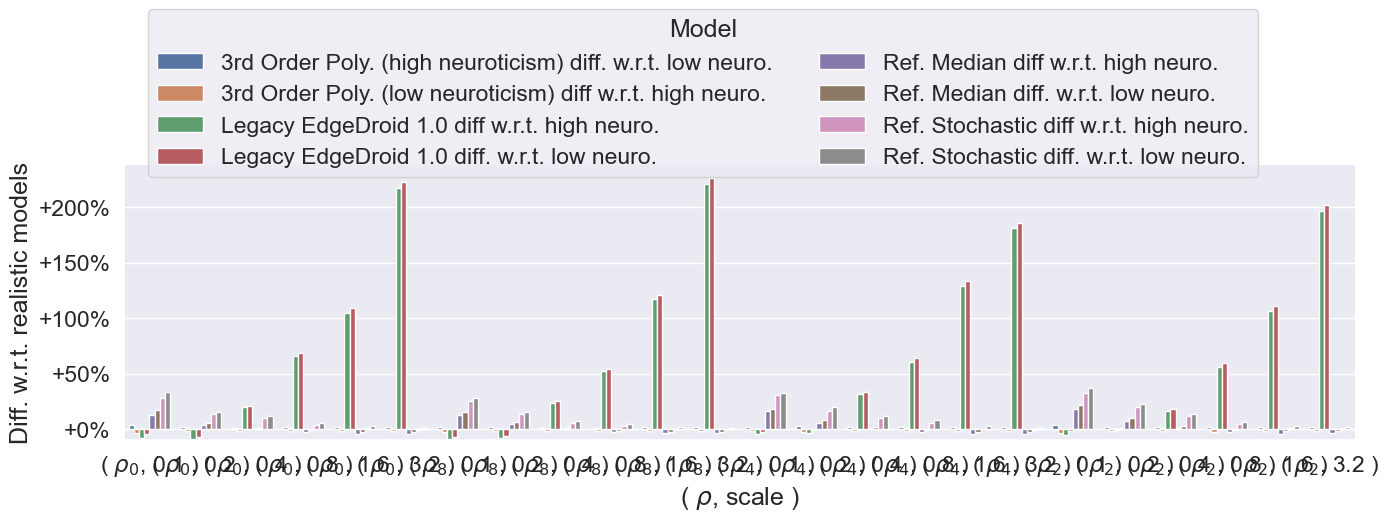

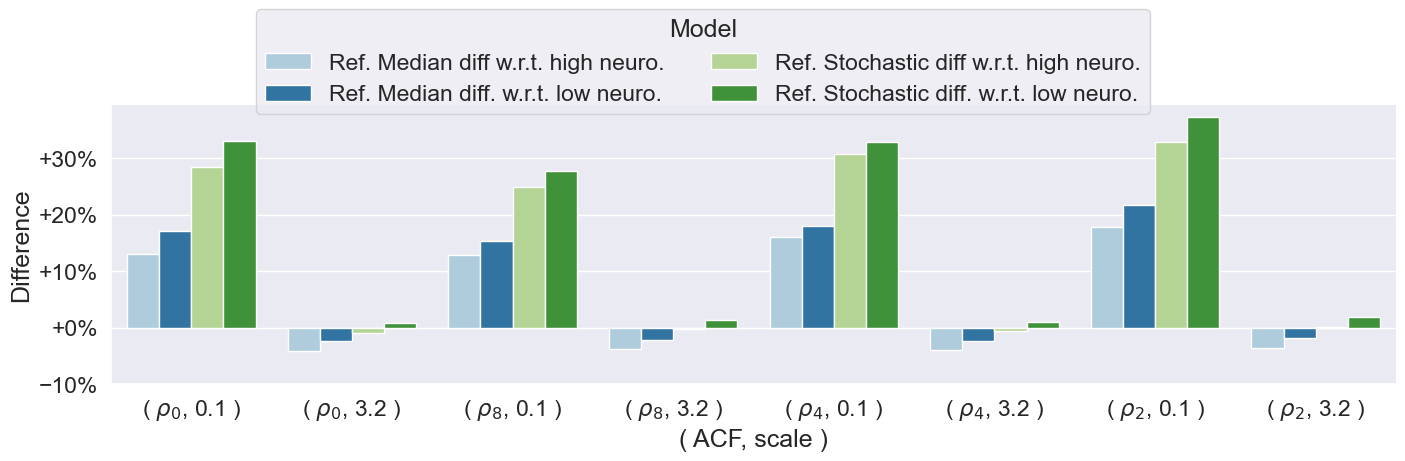

In [104]:
step_data = pd.read_csv('./per_step_delay.csv')

step_data["rho"] = step_data["rho"].replace(rhos).astype(pd.CategoricalDtype(
    [rhos[0.0], rhos[0.125], rhos[0.25], rhos[0.5]],
    ordered=True,
))

step_data["scale"] = step_data["scale"].astype(pd.CategoricalDtype([0.1, 0.2, 0.4, 0.8, 1.6, 3.2], ordered=True))

step_data["model"] = step_data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "3rd-poly-low": "3rd Order Poly. (low neuroticism)",
    "3rd-poly-high": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")

total_durations = step_data.groupby(["model", "rep", "rho", "scale"], observed=True)["step_duration"].sum().reset_index()

sns.set_context("paper")
sns.set(font_scale=1.5)
DOUBLE_COL_FIGW = 7.16

fg = sns.catplot(kind="point", data=total_durations, hue="model", y="step_duration", x="scale", row="rho", aspect=1, legend_out=False)
fg.set_axis_labels(r"Scale", "Task duration [s]")
fg.set_titles(row_template=r"{row_name}")
fg.set(yscale="log")

for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yscale("log", base=2)
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

# fg.set(yscale="log")

fg.legend.set_title("Model")
sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.13), ncols=1)
fg.figure.set_size_inches((2*3.6, 2*7.5))
fg.tight_layout()
plt.show()

# --- rho as x axis

fg = sns.catplot(kind="point", data=total_durations[total_durations["model"] != "Legacy EdgeDroid 1.0"], hue="model", y="step_duration", x="rho", row="scale", aspect=1, legend_out=False)
fg.set_axis_labels(r"ACF", "Task duration [s]")
fg.set_titles(row_template=r"{row_name}")
# fg.set(yscale="log")

for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yscale("log", base=2)
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

fg.legend.set_title("Model")
sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.13), ncols=1)
fg.figure.set_size_inches((2*3.6, 2*7.5))
fg.tight_layout()
plt.show()

# --- end

total_durations_rho2 = total_durations[total_durations["rho"] == rhos[0.5]].copy()
total_durations_rho2["rho"] = total_durations_rho2["rho"].cat.remove_unused_categories()

fg = sns.catplot(kind="bar", data=total_durations_rho2, hue="model", y="step_duration", x="scale", row="rho", aspect=1, legend_out=False)
fg.set_axis_labels(r"Scale", "Task duration [s]")
fg.set_titles(row_template=r"{row_name}")
# fg.set(yscale="log")

for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yscale("log", base=2)
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

# fg.set(yscale="log")

fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.55), ncols=1)
fg.figure.set_size_inches((2*3.6, 2*3.0))
fg.tight_layout()
plt.show()

# diff 
mean_total_durations = (
    total_durations
    .groupby(["model", "rho", "scale"])["step_duration"]
    .mean()
)

a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[1, 2]).transform("first")
diff_wrt_hn = (mean_total_durations - a) / a

a = mean_total_durations.where(mean_total_durations.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[1, 2]).transform("first")
diff_wrt_ln = (mean_total_durations - a) / a

diff_wrt_realistic = pd.merge(diff_wrt_hn, diff_wrt_ln, left_index=True, right_index=True, how="inner", suffixes=("_diff_high_neuro", "_diff_low_neuro")).replace(0.0, np.NaN).reset_index()
diff_wrt_realistic = diff_wrt_realistic.set_index(["model", "rho", "scale"]).stack().reset_index().rename(columns={"level_3": "wrt", 0: "diff"})
diff_wrt_realistic["wrt"] = diff_wrt_realistic["wrt"].apply(lambda x: "diff. w.r.t. low neuro." if x.split("_")[-2] == "low" else "diff w.r.t. high neuro.")

diff_wrt_realistic["rho_scale"] = diff_wrt_realistic[["rho", "scale"]].apply(lambda row: f"( {row.rho[:8]} $, {row.scale} )" , axis=1)
diff_wrt_realistic["model_wrt"] = diff_wrt_realistic[["model", "wrt"]].apply(lambda row: f"{row.model} {row.wrt}" , axis=1)

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(kind="bar", data=diff_wrt_realistic, x="rho_scale", hue="model_wrt", y="diff", legend_out=False)
fg.set_axis_labels(r"( $\rho$, scale )", "Diff. w.r.t. realistic models")
fg.set(ylim=(-0.1, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.35), ncols=2)
fg.figure.set_size_inches((2*7.2, 2*2))
fg.tight_layout()
plt.show()

diff_wrt_realistic_ext = diff_wrt_realistic[
    np.isin(diff_wrt_realistic["scale"], (0.1, 3.2))
    & ~np.isin(diff_wrt_realistic["model"], ("Legacy EdgeDroid 1.0", "3rd Order Poly. (high neuroticism)", "3rd Order Poly. (low neuroticism)"))
    ].copy()
diff_wrt_realistic_ext["model"] = diff_wrt_realistic_ext["model"].cat.remove_unused_categories()
diff_wrt_realistic_ext["scale"] = diff_wrt_realistic_ext["scale"].cat.remove_unused_categories()

sns.set_context("paper")
sns.set(font_scale=1.5)


fg = sns.catplot(kind="bar", data=diff_wrt_realistic_ext, x="rho_scale", hue="model_wrt", y="diff", legend_out=False, palette="Paired")
fg.set_axis_labels(r"( ACF, scale )", "Difference")
fg.set(ylim=(-0.1, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=2)
fg.figure.set_size_inches((2*7.2, 2*2))
fg.tight_layout()
plt.show()


# Difference between step and frame level analyses

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/2286576820.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frame_data_durations = frame_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].mean()
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/2286576820.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  step_data_durations = step_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["ste

Difference in mean duration of step-level experiments w.r.t. frame-level experiments.


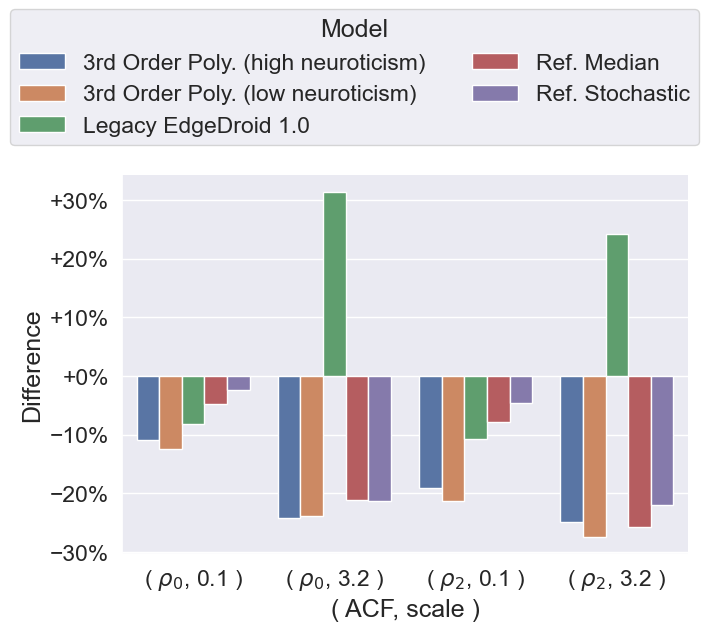

,model,s_param,rho,scale,step_duration,rho_scale
0,3rd Order Poly. (high neuroticism),1.2,$ \rho_0(t) = 0 $,0.1,-0.109204,"( $ \rho_0 $, 0.1 )"
5,3rd Order Poly. (high neuroticism),1.2,$ \rho_0(t) = 0 $,3.2,-0.242597,"( $ \rho_0 $, 3.2 )"
18,3rd Order Poly. (high neuroticism),1.2,$ \rho_2(t) = 2^{-t} $,0.1,-0.190792,"( $ \rho_2 $, 0.1 )"
23,3rd Order Poly. (high neuroticism),1.2,$ \rho_2(t) = 2^{-t} $,3.2,-0.248905,"( $ \rho_2 $, 3.2 )"
24,3rd Order Poly. (low neuroticism),1.2,$ \rho_0(t) = 0 $,0.1,-0.124445,"( $ \rho_0 $, 0.1 )"
29,3rd Order Poly. (low neuroticism),1.2,$ \rho_0(t) = 0 $,3.2,-0.238269,"( $ \rho_0 $, 3.2 )"
42,3rd Order Poly. (low neuroticism),1.2,$ \rho_2(t) = 2^{-t} $,0.1,-0.212069,"( $ \rho_2 $, 0.1 )"
47,3rd Order Poly. (low neuroticism),1.2,$ \rho_2(t) = 2^{-t} $,3.2,-0.274294,"( $ \rho_2 $, 3.2 )"
48,Legacy EdgeDroid 1.0,1.2,$ \rho_0(t) = 0 $,0.1,-0.081179,"( $ \rho_0 $, 0.1 )"
53,Legacy EdgeDroid 1.0,1.2,$ \rho_0(t) = 0 $,3.2,0.313328,"( $ \rho_0 $, 3.2 )"


In [69]:
frame_data_durations = frame_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].mean()
step_data_durations = step_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].mean()

step_frame_duration_diffs = ((step_data_durations - frame_data_durations) / frame_data_durations).reset_index()
step_frame_duration_diffs = step_frame_duration_diffs.loc[
    np.isin(step_frame_duration_diffs["rho"], (r"$ \rho_0(t) = 0 $", r"$ \rho_2(t) = 2^{-t} $"))
    & np.isin(step_frame_duration_diffs["scale"], (0.1, 3.2))
].copy()

step_frame_duration_diffs["rho_scale"] = step_frame_duration_diffs[["rho", "scale"]].apply(lambda row: f"( {row.rho[:8]} $, {row.scale} )" , axis=1)

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(
    kind="bar",
    data=step_frame_duration_diffs,
    y="step_duration",
    x="rho_scale",
    hue="model",
    legend_out=False,
)

fg.set_axis_labels(r"( ACF, scale )", "Difference")
# fg.set(ylim=(-0.3, None))

for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+.0%}")

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.3), ncols=2)
fg.figure.set_size_inches((2*3.6, 2*2.5))
fg.tight_layout()

print("Difference in mean duration of step-level experiments w.r.t. frame-level experiments.")
plt.show()

step_frame_duration_diffs

In [59]:
frame_data_describe = frame_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].describe(percentiles=[])
step_data_describe = step_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].describe(percentiles=[])

describe_diff = frame_data_describe.join(step_data_describe, lsuffix="_frame", rsuffix="_step")
describe_diff

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/4282993130.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frame_data_describe = frame_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho", "scale"])["step_duration"].describe(percentiles=[])
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_21349/4282993130.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  step_data_describe = step_data.groupby(["model", "s_param", "rho", "scale", "rep"])["step_duration"].sum().to_frame().groupby(["model", "s_param", "rho"

count_frame  \
model                              s_param rho                    scale                
3rd Order Poly. (high neuroticism) 1.2     $ \rho_0(t) = 0 $      0.1           30.0   
                                                                  0.2           30.0   
                                                                  0.4           30.0   
                                                                  0.8           30.0   
                                                                  1.6           30.0   
...                                                                              ...   
Ref. Stochastic                    1.2     $ \rho_2(t) = 2^{-t} $ 0.2           30.0   
                                                                  0.4           30.0   
                                                                  0.8           30.0   
                                                                  1.6           30.0   
                                                                  3.2           30.0   

                                                                          mean_frame  \
model                              s_param rho                    scale                
3rd Order Poly. (high neuroticism) 1.2     $ \rho_0(t) = 0 $      0.1     277.441094   
                                                                  0.2     321.876706   
                                                                  0.4     389.772025   
                                                                  0.8     511.117623   
                                                                  1.6     733.988333   
...                                                                              ...   
Ref. Stochastic                    1.2     $ \rho_2(t) = 2^{-t} $ 0.2     367.548242   
                                                                  0.4     445.655159   
                                                                  0.8     553.956671   
                                                                  1.6     714.743684   
                                                                  3.2    1088.386796   

                                                                          std_frame  \
model                              s_param rho                    scale               
3rd Order Poly. (high neuroticism) 1.2     $ \rho_0(t) = 0 $      0.1     10.341449   
                                                                  0.2     14.375984   
                                                                  0.4     20.774350   
                                                                  0.8     46.724509   
                                                                  1.6     74.958808   
...                                                                             ...   
Ref. Stochastic                    1.2     $ \rho_2(t) = 2^{-t} $ 0.2     34.350863   
                                                                  0.4     54.708786   
                                                                  0.8     67.820570   
                                                                  1.6     72.458701   
                                                                  3.2    214.737931   

                                                                          min_frame  \
model                              s_param rho                    scale               
3rd Order Poly. (high neuroticism) 1.2     $ \rho_0(t) = 0 $      0.1    253.751865   
                                                                  0.2    299.116542   
                                                                  0.4    336.186747   
                                                                  0.8    420.319762   
                                                                  1.6    609.094321   
...                                       

In [62]:
std_diff = (describe_diff["std_step"] - describe_diff["std_frame"]) / describe_diff["std_frame"]


model                               s_param  rho                     scale
3rd Order Poly. (high neuroticism)  1.2      $ \rho_0(t) = 0 $       0.1      0.057578
                                                                     0.2     -0.168314
                                                                     0.4     -0.079023
                                                                     0.8      0.068572
                                                                     1.6      0.154473
                                                                                ...   
Ref. Stochastic                     1.2      $ \rho_2(t) = 2^{-t} $  0.2     -0.335576
                                                                     0.4     -0.399406
                                                                     0.8     -0.312356
                                                                     1.6     -0.045606
                                                       